Load all packages you need.

In [1]:
# Import essential data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, metrics, model_selection
import sweetviz

# Enable matplotlib inline for Jupyter
%matplotlib inline

Read the data.

In [2]:
# Read the data from the /data/ directory
data = pd.read_csv('../data/diabetes.csv')

# Display the first few rows of the dataframe
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Let's deal with the missing data points in "BloodPressure". <br>
First remove the outlier from the last coding break.<br>
Create a copy of the outlier-filtered data frame and impute the missing values with the "BloodPressure" median value.

In [3]:
# First, create a copy of the original dataframe
data_cleaned = data.copy()

# Step 1: Remove the outliers identified in the previous coding break using Tukey's fence
# Calculate Tukey's fence for outlier detection
Q1 = data_cleaned[data_cleaned['BloodPressure'] != 0]['BloodPressure'].quantile(0.25)
Q3 = data_cleaned[data_cleaned['BloodPressure'] != 0]['BloodPressure'].quantile(0.75)
IQR = Q3 - Q1

# Define Tukey's fence boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data_cleaned = data_cleaned[
    (data_cleaned['BloodPressure'] == 0) |  # Keep zeros for now as they will be imputed
    ((data_cleaned['BloodPressure'] >= lower_bound) & 
     (data_cleaned['BloodPressure'] <= upper_bound))
]

print(f"Original data shape: {data.shape}")
print(f"After outlier removal shape: {data_cleaned.shape}")
print(f"Number of records removed: {data.shape[0] - data_cleaned.shape[0]}")

# Step 2: Create a copy of the outlier-filtered dataframe
data_imputed = data_cleaned.copy()

# Step 3: Calculate the median BloodPressure (excluding zeros)
bp_median = data_cleaned[data_cleaned['BloodPressure'] != 0]['BloodPressure'].median()
print(f"BloodPressure median value (excluding zeros): {bp_median}")

# Step 4: Impute missing values (zeros) with the median value
data_imputed.loc[data_imputed['BloodPressure'] == 0, 'BloodPressure'] = bp_median

# Verify the imputation
zero_count_before = (data_cleaned['BloodPressure'] == 0).sum()
zero_count_after = (data_imputed['BloodPressure'] == 0).sum()

print(f"Number of zeros before imputation: {zero_count_before}")
print(f"Number of zeros after imputation: {zero_count_after}")

# Display the first few rows of the imputed dataframe
data_imputed.head()

Original data shape: (768, 9)
After outlier removal shape: (754, 9)
Number of records removed: 14
BloodPressure median value (excluding zeros): 72.0
Number of zeros before imputation: 35
Number of zeros after imputation: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Create a second copy of the outlier-filtered data frame. <br>
Perform a hot-deck/distribution imputation. First, estimate the distribution parameters of "BloodPressure". Then, sample the values used for imputation.

Estimated distribution parameters:
Mean: 72.12
Standard deviation: 11.24


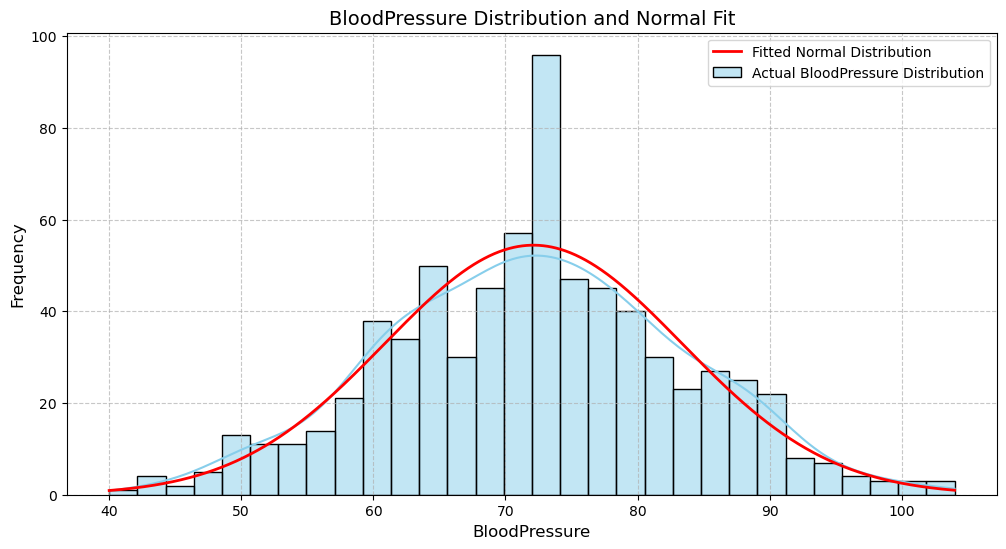

Number of missing values to impute: 35

Imputation statistics:
Before - zeros count: 35
After - zeros count: 0
Original BP mean (excluding zeros): 72.12
Original BP std (excluding zeros): 11.24
Imputed BP mean: 70.62
Imputed BP std: 10.48
Overall BP mean after imputation: 72.05


/tmp/ipykernel_633178/3059761.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[77.7 70.6 79.4 89.2 69.5 69.5 89.9 80.7 66.8 78.2 66.9 66.9 74.8 50.6
 52.7 65.8 60.7 75.6 61.9 56.2 88.6 69.6 72.9 56.1 66.  73.4 59.2 76.3
 65.4 68.8 65.4 92.9 72.  60.2 81.4]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_hotdeck.loc[data_hotdeck['BloodPressure'] == 0, 'BloodPressure'] = imputed_values


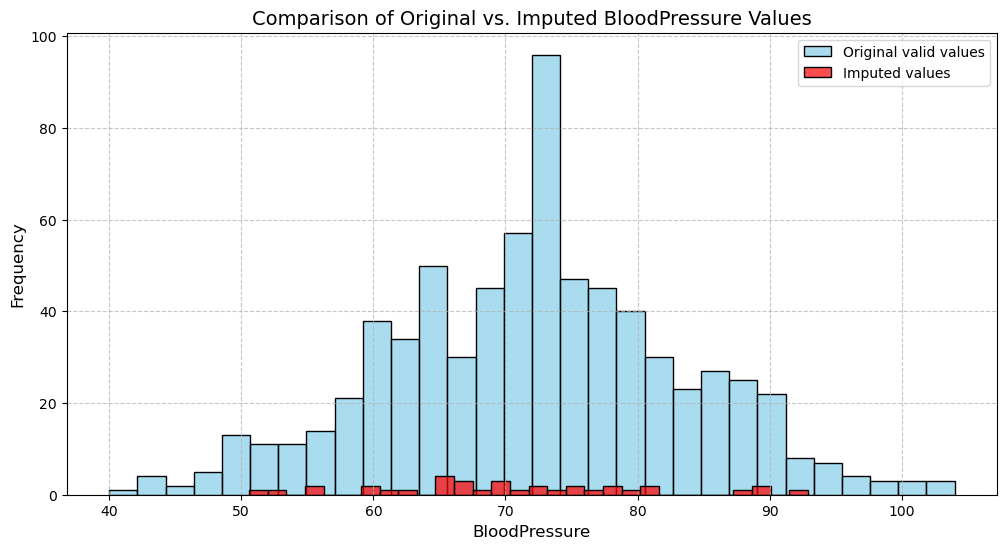

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35,0,33.6,0.627,50,1
1,1,85,66.0,29,0,26.6,0.351,31,0
2,8,183,64.0,0,0,23.3,0.672,32,1
3,1,89,66.0,23,94,28.1,0.167,21,0
4,0,137,40.0,35,168,43.1,2.288,33,1


In [6]:
# Step 1: Create a second copy of the outlier-filtered data frame
data_hotdeck = data_cleaned.copy()  # Assuming data_cleaned is the outlier-filtered dataframe from previous step

# Step 2: Estimate the distribution parameters of "BloodPressure" (excluding zeros)
# First, get the non-zero blood pressure values
valid_bp = data_cleaned[data_cleaned['BloodPressure'] != 0]['BloodPressure']

# Step 3: Fit a normal distribution to the valid blood pressure data
from scipy import stats
# Estimate mean and standard deviation from valid blood pressure data
mean_bp = valid_bp.mean()
std_bp = valid_bp.std()

print(f"Estimated distribution parameters:")
print(f"Mean: {mean_bp:.2f}")
print(f"Standard deviation: {std_bp:.2f}")

# Step 4: Visualize the actual distribution vs. the fitted normal distribution
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 6))

# Plot histogram of actual data
sns.histplot(valid_bp, bins=30, kde=True, color='skyblue', 
             label='Actual BloodPressure Distribution')

# Generate points from the fitted normal distribution
x = np.linspace(valid_bp.min(), valid_bp.max(), 1000)
y = stats.norm.pdf(x, mean_bp, std_bp)
y = y * (len(valid_bp) * (valid_bp.max() - valid_bp.min()) / 30)  # Scale to match histogram

# Plot the fitted normal distribution
plt.plot(x, y, 'r-', linewidth=2, label='Fitted Normal Distribution')

plt.title('BloodPressure Distribution and Normal Fit', fontsize=14)
plt.xlabel('BloodPressure', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 5: Count how many missing values we need to impute
missing_count = (data_hotdeck['BloodPressure'] == 0).sum()
print(f"Number of missing values to impute: {missing_count}")

# Step 6: Generate random samples from the estimated normal distribution
# Use random seed for reproducibility
np.random.seed(42)
imputed_values = np.random.normal(mean_bp, std_bp, missing_count)

# Round to one decimal place to be consistent with original data
imputed_values = np.round(imputed_values, 1)

# Step 7: Replace missing values with the sampled values
data_hotdeck.loc[data_hotdeck['BloodPressure'] == 0, 'BloodPressure'] = imputed_values

# Step 8: Verify imputation
print("\nImputation statistics:")
print(f"Before - zeros count: {(data_cleaned['BloodPressure'] == 0).sum()}")
print(f"After - zeros count: {(data_hotdeck['BloodPressure'] == 0).sum()}")
print(f"Original BP mean (excluding zeros): {valid_bp.mean():.2f}")
print(f"Original BP std (excluding zeros): {valid_bp.std():.2f}")
print(f"Imputed BP mean: {data_hotdeck[data_cleaned['BloodPressure'] == 0]['BloodPressure'].mean():.2f}")
print(f"Imputed BP std: {data_hotdeck[data_cleaned['BloodPressure'] == 0]['BloodPressure'].std():.2f}")
print(f"Overall BP mean after imputation: {data_hotdeck['BloodPressure'].mean():.2f}")

# Step 9: Compare the distributions visually
plt.figure(figsize=(12, 6))

# Plot histogram of original valid data
sns.histplot(valid_bp, bins=30, color='skyblue', 
             alpha=0.7, label='Original valid values')

# Plot histogram of imputed values
sns.histplot(data_hotdeck[data_cleaned['BloodPressure'] == 0]['BloodPressure'], 
             bins=30, color='red', alpha=0.7, label='Imputed values')

plt.title('Comparison of Original vs. Imputed BloodPressure Values', fontsize=14)
plt.xlabel('BloodPressure', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Display the first few rows of the imputed dataframe
data_hotdeck.head()

Create a third copy of the outlier-filtered data frame. <br>
Perform a regression-based imputation. First, choose 3 variables that are correlated with "BloodPressure" (Hint, create a correlation matrix or have a look at the "Associations"-Button in sweetviz).<br>
Second, fit a linear regression model with those three variables as predictors. Let's ignore for the moment that the other variables might also include outlier and missing data.<br>
Now, use the regression model to estimate the imputed value for each missing data point.

Now plot the original data next to the imputed data. Inspect the differences!